# Economic Complexity Index correlation
In this notebook we explore the hypothesis that financial social capital captures similar information than the index of economic complexity. 

For this purpose, we downloaded the index of economic complexity from the observatory of economic complexity https://legacy.oec.world/en/rankings/country/eci/.

In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import country_converter as coco

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr

from linearmodels.panel import BetweenOLS, PooledOLS
import patsy

In [3]:
data_path = os.path.join('s3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/', 'raw', 'eci_country_rankings.csv')
df_eci = pd.read_csv(data_path)
df_eci.columns = [c.lower() for c in df_eci]

iso3_converter = dict(zip(list(df_eci.country.unique()), coco.convert(list(df_eci.country.unique()))))
df_eci['country'] = df_eci.country.map(iso3_converter)

In [4]:
df_model = pd.read_parquet(os.path.join(output_filepath, 'panel_data.parquet'))
df_model = df_model[df_model.year.between(1995, 2016)]

centralities = ['hubs', 'authorities', 'favor']
networks = ['financial', 'goods', 'human']

for c in [f'{n}_{c}' for c in centralities for n in networks]:
    df_model[c] = df_model[c].map(lambda x: np.log1p(x*1.e8))

all_centralities = [f'{n}_{c}' for c in centralities for n in networks]
all_centralities.remove('goods_favor')
all_centralities.remove('financial_favor')

In [5]:
df = df_model.merge(df_eci, on=['year', 'country'], how='inner')

/home/ubuntu/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


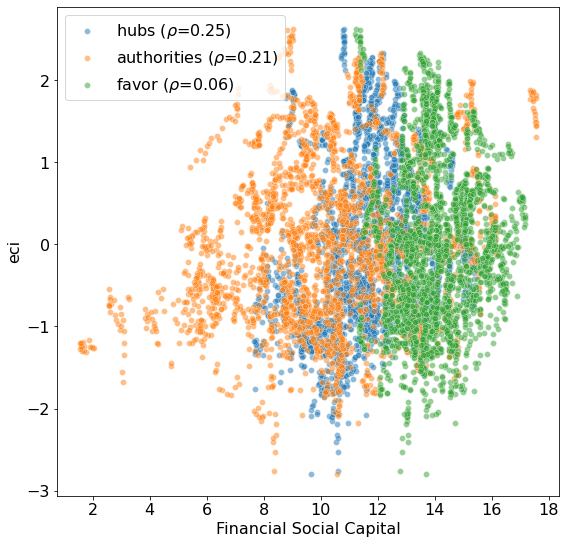

In [6]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(9,9))

network = 'human'
#network = 'financial'
#network = 'goods'

for nc in all_centralities:
    
    n, c = nc.split('_')
    if network == n:
        sns.scatterplot(df[nc], 
                    y = df['eci'], 
                    ax=ax, 
                    label = c, 
                    alpha = 0.5)

plt.xlabel('Financial Social Capital')
plt.legend()


leg = ax.get_legend()
L_labels = leg.get_texts()
for i, l in enumerate(L_labels):
    centrality = l.get_text()
    corr = pearsonr(df['eci'], df[network + '_' + centrality])[0]
    text = centrality + f' ($\\rho$={round(corr,2)})'
    L_labels[i].set_text(text)
    
    
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'{network}_social_capital_vs_eci.png')
plt.savefig(save_to)    
plt.show()

In [7]:
df_correlations = pd.DataFrame({'centrality':centralities})

df_correlations['eci pearson'], df_correlations['eci p-value pearsonr'] = zip(*df_correlations.centrality.map(lambda x: pearsonr(df['eci'], df['financial_'+x])))
df_correlations['eci spearman'], df_correlations['eci p-value spearman'] = zip(*df_correlations.centrality.map(lambda x: spearmanr(df['eci'], df['financial_'+x])))

df_no_missing = df.dropna(subset = ['eci+'])
df_correlations['eci+ pearson'], df_correlations['eci+ p-value pearsonr'] = zip(*df_correlations.centrality.map(lambda x: pearsonr(df_no_missing['eci+'], df_no_missing['financial_'+x])))
df_correlations['eci+ spearman'], df_correlations['eci+ p-value spearman'] = zip(*df_correlations.centrality.map(lambda x: spearmanr(df_no_missing['eci+'], df_no_missing['financial_'+x])))

df_correlations

,centrality,eci pearson,eci p-value pearsonr,eci spearman,eci p-value spearman,eci+ pearson,eci+ p-value pearsonr,eci+ spearman,eci+ p-value spearman
0,hubs,0.532064,1.665132e-189,0.575479,1.337000e-228,0.503020,1.293059e-157,0.579353,4.111092e-220
1,authorities,0.610617,7.963687e-265,0.641204,2.729905e-300,0.594421,1.696742e-234,0.665600,4.496733e-314
2,favor,0.280680,3.774992e-48,0.304955,6.180403e-57,0.255740,5.857341e-38,0.284770,5.042219e-47


In [8]:
f = 'eci ~ financial_pagerank + financial_gfi + financial_bridging + financial_favor + 1'
y, X = patsy.dmatrices(f, df.set_index(['country','year']),  return_type='dataframe')

model = PooledOLS(y,X)
pooled_res = model.fit()

pooled_res

Dep. Variable:,eci,R-squared:,0.3826
Estimator:,PooledOLS,R-squared (Between):,0.4285
No. Observations:,2593,R-squared (Within):,-0.6254
Date:,"Thu, Aug 26 2021",R-squared (Overall):,0.3826
Time:,14:46:49,Log-likelihood,-3024.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,400.88
Entities:,130,P-value,0.0000
Avg Obs:,19.946,Distribution:,"F(4,2588)"
Min Obs:,1.0000,,
Max Obs:,22.000,F-statistic (robust):,400.88
